In [1]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.applications.vgg19 import VGG19

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [4]:
dataset_iphone = cargar_datos('Datos preprocesados EMD/iPhone/EMD', 'Datos preprocesados EMD/iPhone/NO EMD')

In [5]:
dataset_samsung = cargar_datos('Datos preprocesados EMD/Samsung/EMD', 'Datos preprocesados EMD/Samsung/NO EMD')

In [6]:
dataset = cargar_datos('Datos preprocesados EMD/OCT/EMD', 'Datos preprocesados EMD/OCT/NO EMD')

### TRAIN: OCT + Samsung

### TEST: iPhone

In [7]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [8]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [9]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [10]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [11]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [12]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=2, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/2
6/6 [==============================] - 12s 2s/step - loss: 4.7768 - accuracy: 0.5028 - val_loss: 7.1417 - val_accuracy: 0.0444
Epoch 2/2
6/6 [==============================] - 9s 2s/step - loss: 2.8498 - accuracy: 0.7910 - val_loss: 17.5324 - val_accuracy: 0.0000e+00


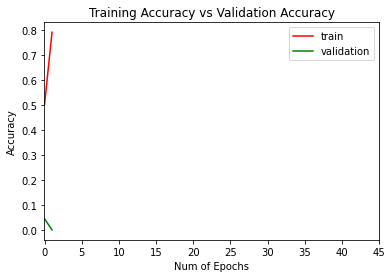

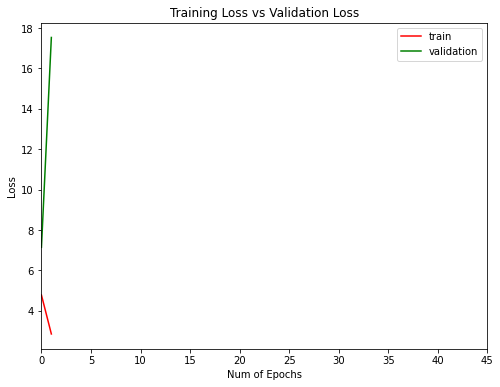

In [14]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

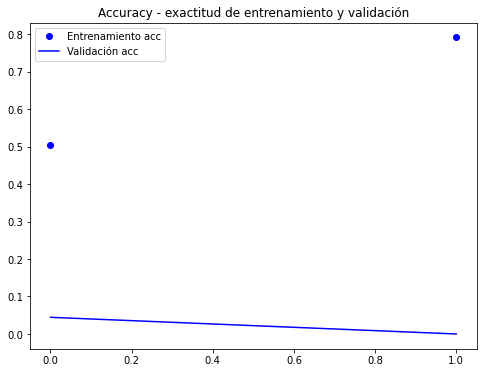

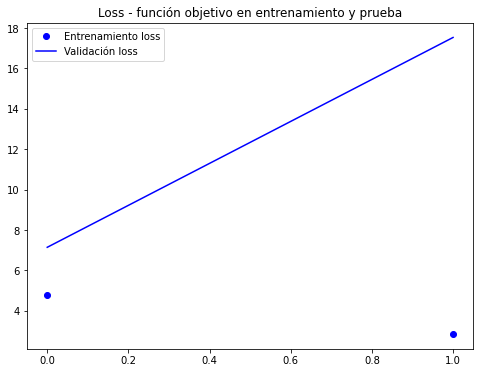

In [15]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 5s 1s/step


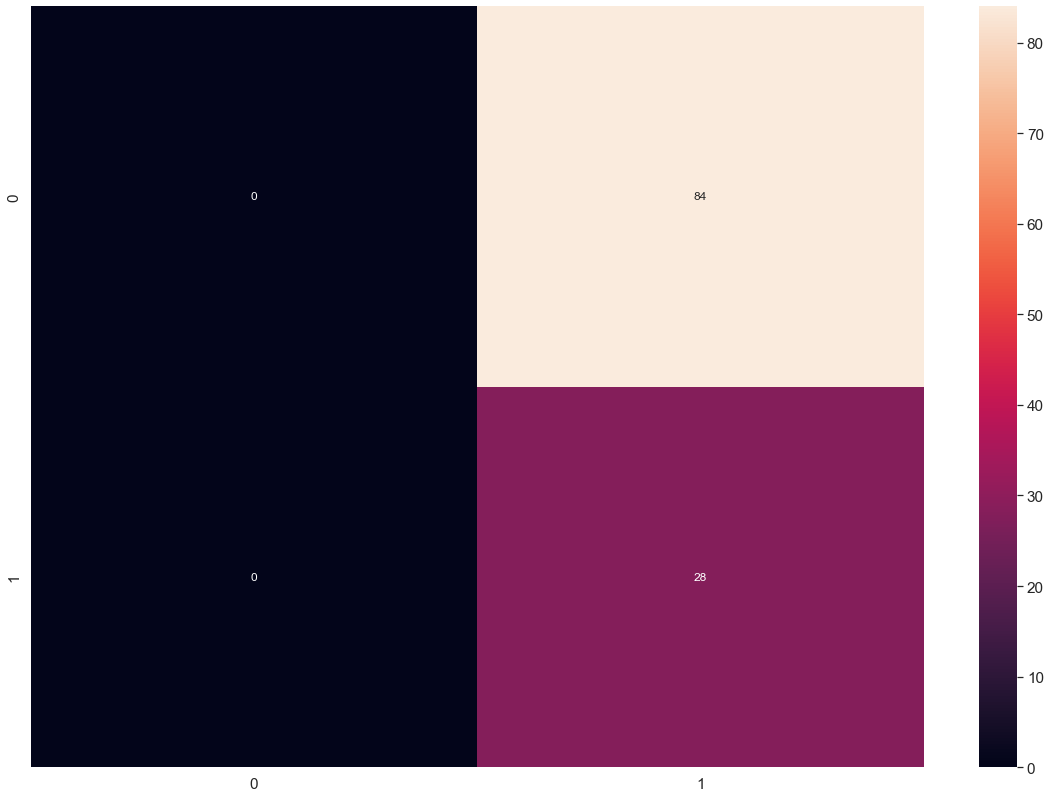

In [16]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [17]:
score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 12.505895614624023
Test accuracy: 0.25


In [18]:
predictions = model.predict(test_ds)

4/4 [==============================] - 5s 1s/step


In [21]:
print(predictions)

[[1.8546935e-08 1.0000000e+00]
 [1.7323018e-05 9.9998271e-01]
 [1.5348851e-07 9.9999988e-01]
 [4.0864288e-05 9.9995911e-01]
 [3.1245713e-12 1.0000000e+00]
 [4.2949573e-06 9.9999571e-01]
 [9.9114850e-10 1.0000000e+00]
 [2.8381168e-04 9.9971622e-01]
 [1.4457348e-08 1.0000000e+00]
 [3.2127748e-08 1.0000000e+00]
 [1.3620224e-09 1.0000000e+00]
 [2.5331815e-06 9.9999750e-01]
 [8.1828382e-08 9.9999988e-01]
 [1.8929576e-06 9.9999809e-01]
 [5.1765581e-11 1.0000000e+00]
 [3.7443133e-05 9.9996257e-01]
 [2.5828570e-08 1.0000000e+00]
 [5.7280562e-07 9.9999940e-01]
 [3.5828656e-08 1.0000000e+00]
 [1.1335657e-04 9.9988663e-01]
 [3.9872933e-10 1.0000000e+00]
 [8.7508681e-08 9.9999988e-01]
 [7.3425412e-11 1.0000000e+00]
 [5.6947056e-07 9.9999940e-01]
 [4.1912585e-06 9.9999583e-01]
 [2.0433287e-04 9.9979573e-01]
 [1.9317195e-12 1.0000000e+00]
 [2.9431890e-09 1.0000000e+00]
 [1.4366971e-11 1.0000000e+00]
 [4.5419336e-04 9.9954575e-01]
 [5.9398362e-14 1.0000000e+00]
 [3.1925363e-06 9.9999678e-01]
 [2.2670

In [ ]:
y_pred_iphone = list(map(lambda x: list(x).index(max(x)),predictions))

In [22]:
print(test_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [23]:
print(to_categorical(test_labels, num_classes=2))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

In [46]:
print(test_labels_categorical[0][0])

0.0


In [ ]:
test_

In [52]:
roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')

print(roc_score)

0.45450680272108845


In [26]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels_categorical, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.76      0.93      0.83        84
           1       0.33      0.11      0.16        28

    accuracy                           0.72       112
   macro avg       0.55      0.52      0.50       112
weighted avg       0.65      0.72      0.67       112



### TRAIN: OCT + iPhone

### TEST: Samsung

In [27]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [28]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [29]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [30]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [31]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
6/6 [==============================] - 8s 1s/step - loss: 3.5231 - accuracy: 0.6593 - val_loss: 9.4789 - val_accuracy: 0.1739
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 2.4666 - accuracy: 0.7033 - val_loss: 17.0189 - val_accuracy: 0.0870
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 1.6190 - accuracy: 0.8187 - val_loss: 3.5888 - val_accuracy: 0.5000
Epoch 4/200
6/6 [==============================] - 9s 1s/step - loss: 0.3481 - accuracy: 0.9066 - val_loss: 3.2651 - val_accuracy: 0.5435
Epoch 5/200
6/6 [==============================] - 9s 1s/step - loss: 0.2798 - accuracy: 0.8956 - val_loss: 1.9440 - val_accuracy: 0.6522
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 3.3815 - val_accuracy: 0.5435
Epoch 7/200
6/6 [==============================] - 9s 2s/step - loss: 0.0759 - accuracy: 0.9835 - val_loss: 3.2068 - val_accuracy: 0.5652
Epoch 8/200
6/6 [================

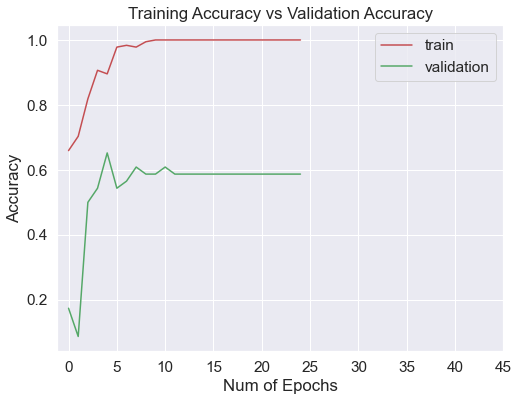

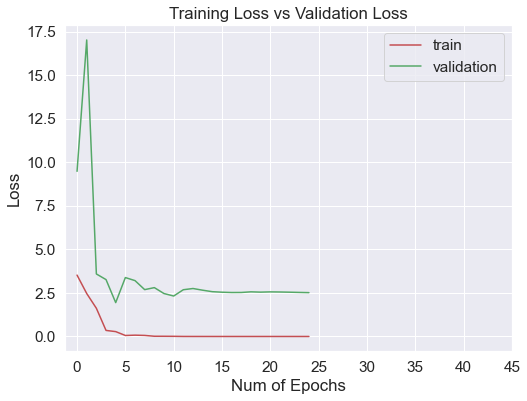

In [33]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

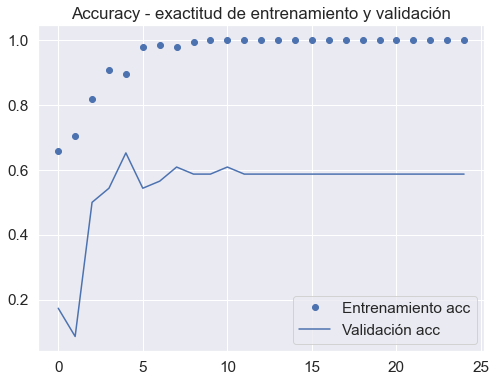

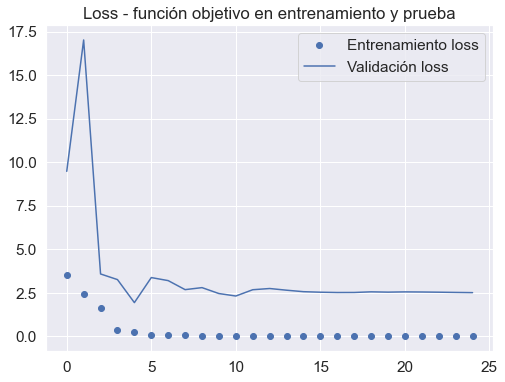

In [34]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 857ms/step


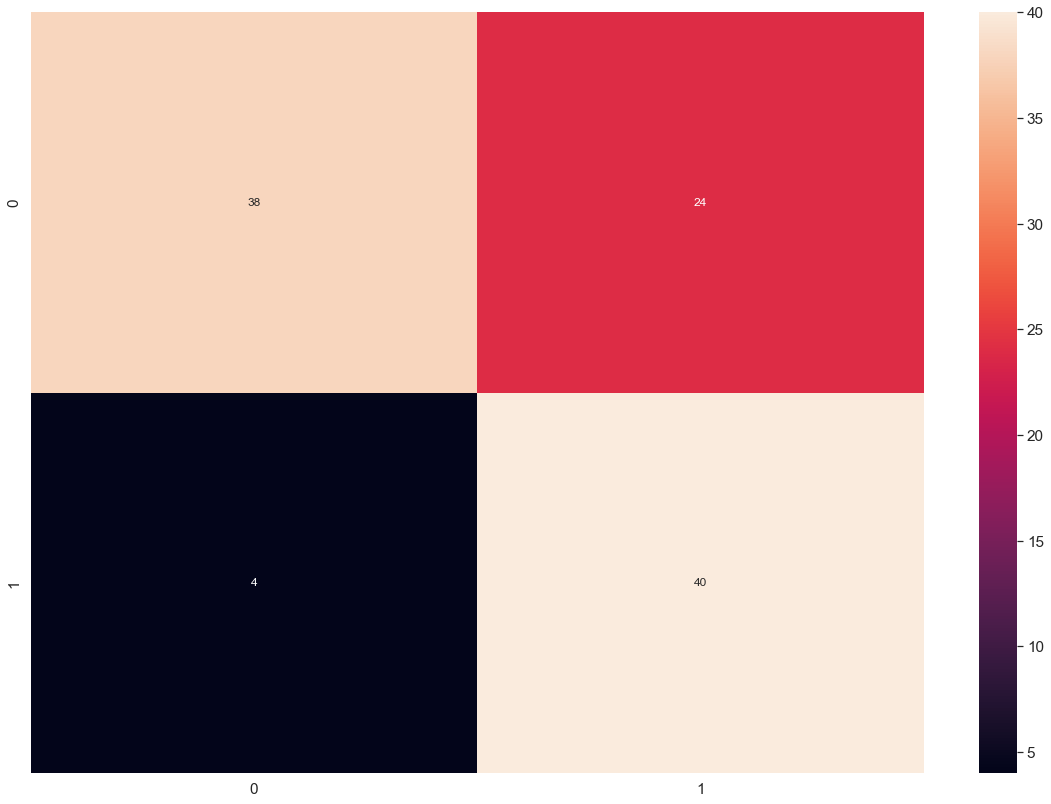

In [35]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [36]:
score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 1.1946626901626587
Test accuracy: 0.7358490824699402


In [37]:
predictions = model.predict(test_ds)

4/4 [==============================] - 3s 698ms/step


In [38]:
roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')

print(roc_score)

0.843108504398827


In [39]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels_categorical, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.90      0.61      0.73        62
           1       0.62      0.91      0.74        44

    accuracy                           0.74       106
   macro avg       0.76      0.76      0.74       106
weighted avg       0.79      0.74      0.73       106



# PRUEBAS VGG19

### TRAIN: OCT + Samsung

### TEST: iPhone

In [40]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [41]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [42]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [45]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [46]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [47]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 7.8270 - accuracy: 0.4689 - val_loss: 25.7221 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 2.3620 - accuracy: 0.7458 - val_loss: 11.3317 - val_accuracy: 0.0222
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 0.6753 - accuracy: 0.7797 - val_loss: 3.4458 - val_accuracy: 0.2667
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3093 - accuracy: 0.8757 - val_loss: 2.7843 - val_accuracy: 0.4667
Epoch 5/200
6/6 [==============================] - 11s 2s/step - loss: 0.1943 - accuracy: 0.9322 - val_loss: 6.0793 - val_accuracy: 0.0889
Epoch 6/200
6/6 [==============================] - 11s 2s/step - loss: 0.1565 - accuracy: 0.9322 - val_loss: 6.0616 - val_accuracy: 0.0889
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.1654 - accuracy: 0.9153 - val_loss: 2.8274 - val_accuracy: 0.4444
Epoch 8/200
6/6 [=====

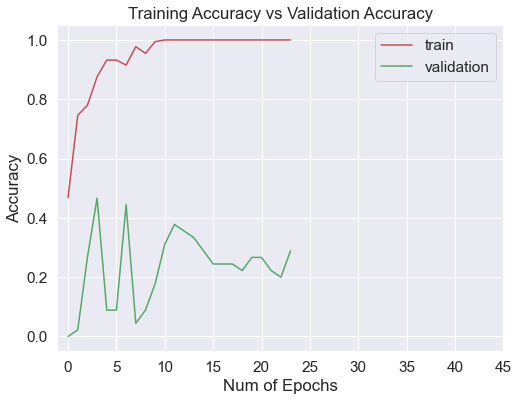

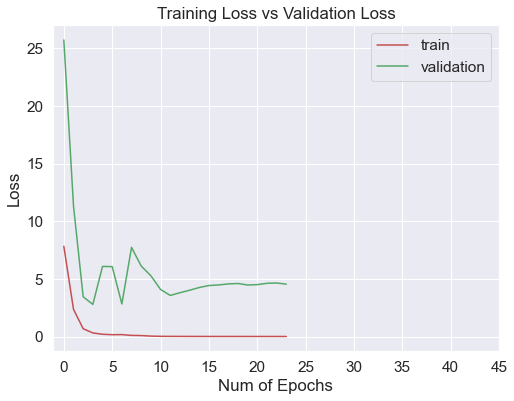

In [49]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

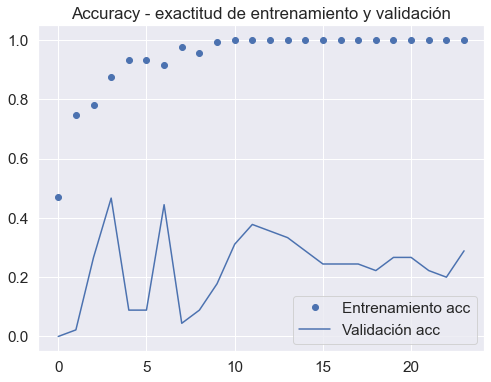

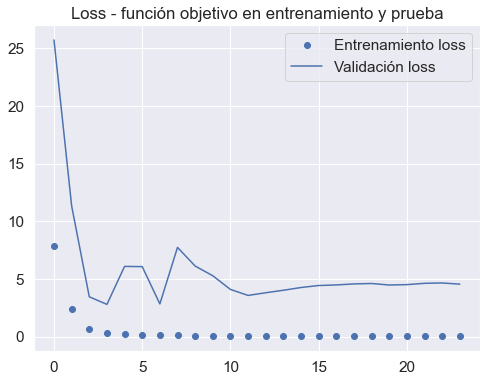

In [50]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 5s 1s/step


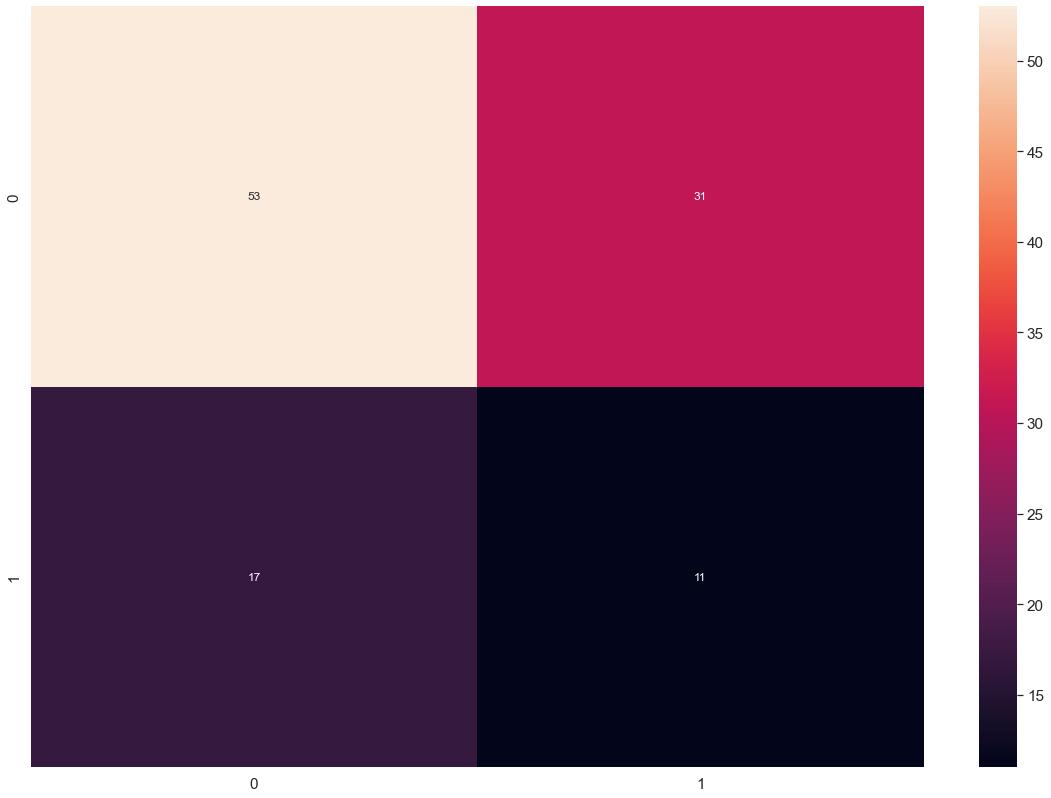

In [51]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [52]:
score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 1.443541407585144
Test accuracy: 0.5714285969734192


In [53]:
predictions = model.predict(test_ds)

4/4 [==============================] - 5s 1s/step


In [54]:
roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')

print(roc_score)

0.5242346938775511


In [55]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels_categorical, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.76      0.63      0.69        84
           1       0.26      0.39      0.31        28

    accuracy                           0.57       112
   macro avg       0.51      0.51      0.50       112
weighted avg       0.63      0.57      0.59       112



### TRAIN: OCT + iPhone

### TEST: Samsung

In [56]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [57]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [58]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [59]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [60]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [61]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 13.6586 - accuracy: 0.4945 - val_loss: 9.9135 - val_accuracy: 0.1304
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 5.7846 - accuracy: 0.4011 - val_loss: 13.2057 - val_accuracy: 0.0652
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 2.8672 - accuracy: 0.7802 - val_loss: 2.1261 - val_accuracy: 0.6087
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 1.4518 - accuracy: 0.5165 - val_loss: 3.6121 - val_accuracy: 0.3696
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.8042 - accuracy: 0.8846 - val_loss: 2.1811 - val_accuracy: 0.5435
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.6328 - accuracy: 0.7308 - val_loss: 2.5599 - val_accuracy: 0.5217
Epoch 7/200
6/6 [==============================] - 11s 2s/step - loss: 0.2924 - accuracy: 0.9121 - val_loss: 1.6933 - val_accuracy: 0.5652
Epoch 8/200
6/6 [========

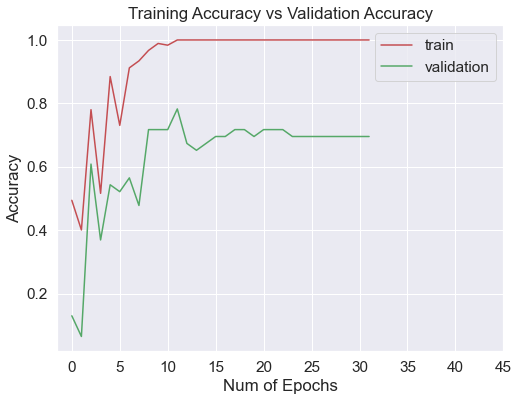

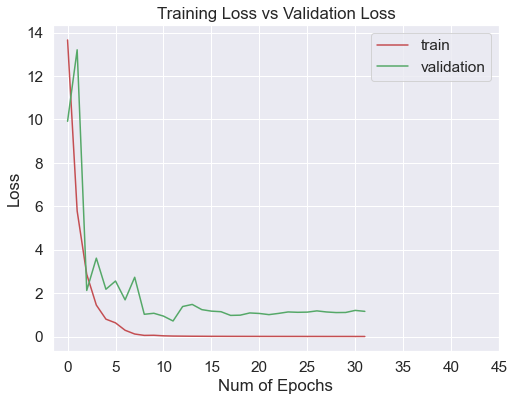

In [63]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

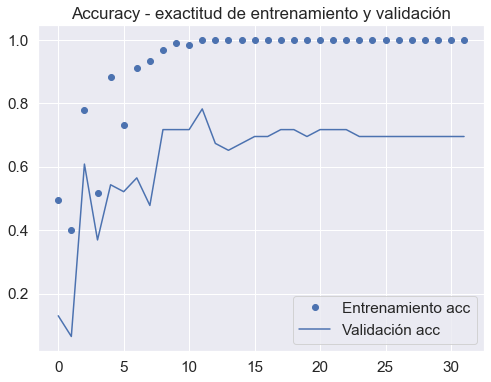

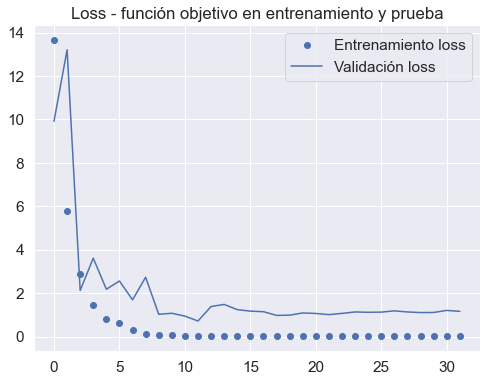

In [64]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 889ms/step


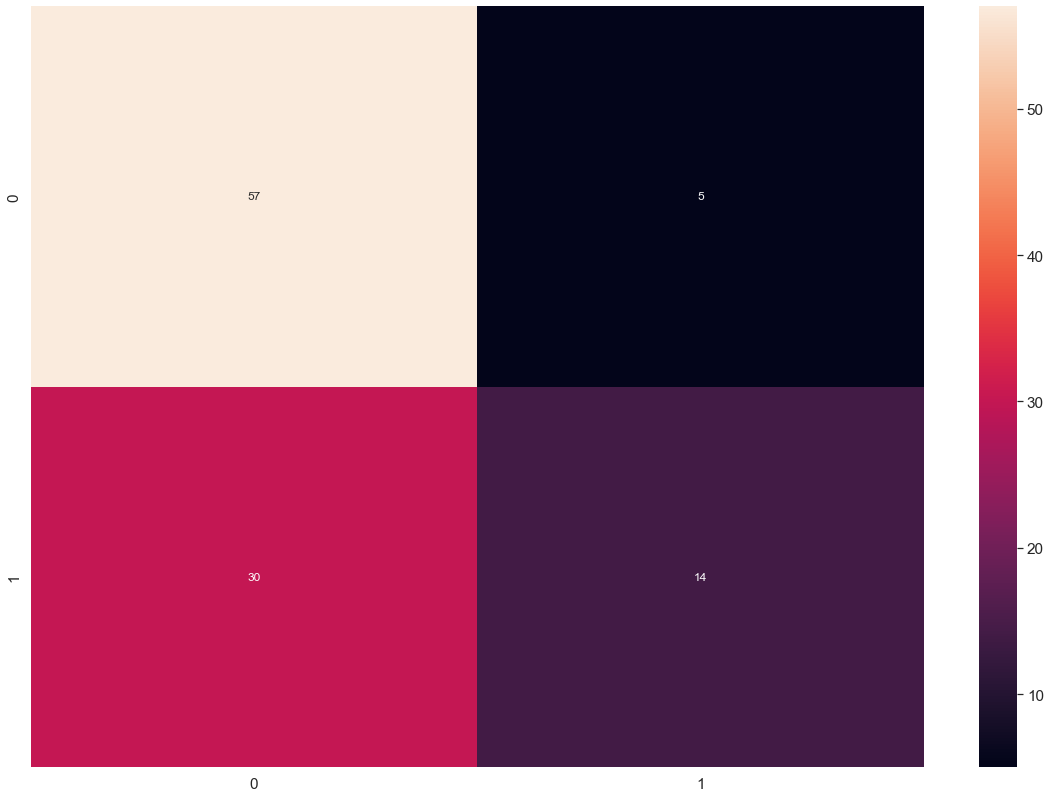

In [65]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [66]:
score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 2.0253710746765137
Test accuracy: 0.6698113083839417


In [67]:
predictions = model.predict(test_ds)

4/4 [==============================] - 4s 888ms/step


In [68]:
roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')

print(roc_score)

0.6990469208211143


In [69]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels_categorical, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.66      0.92      0.77        62
           1       0.74      0.32      0.44        44

    accuracy                           0.67       106
   macro avg       0.70      0.62      0.60       106
weighted avg       0.69      0.67      0.63       106

